# The surface of revolution of minimum area

The well-known surface of revolution of minimum area problem dates back to Euler. This is a problem of calculus of variations for which it is easy to have the analytic solutions. But here, as we use this simple problem to illustrate the use of the `control-toolbox`, we consider the optimal control version:

$$
    \left\{\begin{array}{l}
    \displaystyle \min\, \int_0^{2} x(t)\,\sqrt{1+u^2(t)}\,\mathrm{d}t\\[1em]
    \dot{x}(t) = u(t), \quad u(t)\in\R, \\[0.5em]
    x(0) = 1, \quad x(2) = 1.
    \end{array}
    \right.
$$

## Packages

In [1]:
using Pkg
Pkg.activate(".")
#
using DifferentialEquations
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using OptimalControl
using Plots
using Roots     # solve an equation f(x)=0 where f is from R to R
using Test

  Activating project at `~/Boulot/recherche/logiciels/simulations/2023_10_25_Indirect_Conjugate`


## Control-toolbox definition of the problem

To define this problem in our package we have to type:

In [2]:
t0 = 0
tf = 2
x0 = 1
xf = 1
@def ocp begin
    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control
    x(t0) == x0
    x(tf) == xf
    ẋ(t) ==  u(t)
    ∫(x(t)*(1 + u(t)^2)^(1/2)) → min
end


┌───────┬───────┬─────────┬──────────┬───────────┬─────────────┐
│ times │ state │ control │ dynamics │ objective │ constraints │
├───────┼───────┼─────────┼──────────┼───────────┼─────────────┤
│    ✅ │    ✅ │      ✅ │       ✅ │        ✅ │          ✅ │
└───────┴───────┴─────────┴──────────┴───────────┴─────────────┘


t ∈ [t0, tf], time
x ∈ R, state
u ∈ R, control
x(t0) == x0
x(tf) == xf
ẋ(t) == u(t)
∫(x(t) * (1 + u(t) ^ 2) ^ (1 / 2)) → min


## Hamiltonian flow

The pseudo-Hamiltonian is
$$H(x,p,u) =  -x\sqrt{1+u^2} + up,$$
and for $|p| < |x|$ the maximization of the pseudo-Hamiltonian provides the control with respect to the state and the costate (or covector):
$$u(x,p) = \mathrm{sign}(x) \frac{p}{\sqrt{x^2-p^2}}.$$

Then, we can define the Hamiltonian $\mathbf{H}(x,p)=H(x, p, u(x,p))$.
We note $z(t) = (x(t),p(t))$, then, the Hamiltonian flow is the function
$\phi(\cdot, z_0) = \phi(\cdot, x_0, p_0)$ solution of the initial value problem

$$
    \dot{z} = \vec{\mathbf{H}}(z) = (\dot{x}, \dot{p}) =
    \left(
        \dfrac{\partial \mathbf{H}}{\partial p}(z), 
        -\dfrac{\partial \mathbf{H}}{\partial x}(z)
    \right), \quad
    z(0) = z_0 = (x_0,p_0).
$$

In [3]:
# Control in feedback form
u(x, p) = sign(x[1])*p[1]*sqrt(1. /(x[1]^2-p[1]^2))  

# The Flow function computes the Hamiltonian flow
ocp_flow = Flow(ocp, u);

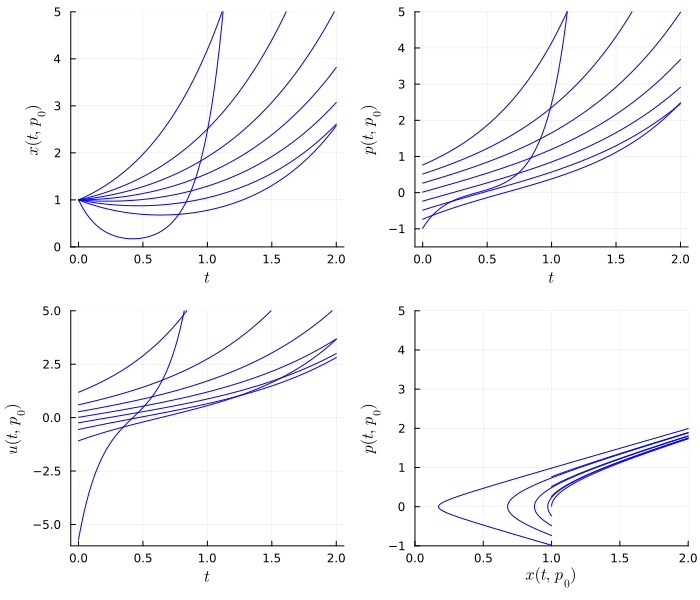

In [10]:
# Compute flows for different values of the initial costate p_0
p0s = -0.985:0.25:0.98      # interval of p_0
N  = 100
tspan = range(t0, tf, N)    # time interval
plt_x = plot()              # plot of the state x(t)
plt_p = plot()              # plot of the costate p(t)
plt_u = plot()              # plot of the control u(t)
plt_phase = plot()          # plot (x, p)
color_trajectory = :blue

for p0 in p0s # plot for each p_0 in p0s 

    flow_p0 = ocp_flow((t0, tf), x0, p0, reltol=1e-8, abstol=1e-8, saveat=tspan)

    T = tspan
    Z = flow_p0.(tspan)
    X = [Z[i][1] for i in 1:N]
    P = [Z[i][2] for i in 1:N]

    plot!(plt_x, T, X, color=color_trajectory)
    plot!(plt_p, T, P, color=color_trajectory)
    plot!(plt_u, T, u.(X, P), color=color_trajectory)  
    plot!(plt_phase, X, P, color=color_trajectory)

end

# Plots
plot!(plt_x, xlabel=L"t", ylabel=L"x(t,p_0)", legend=false, ylims=(0.,5.))
plot!(plt_p, xlabel=L"t", ylabel=L"p(t,p_0)", legend=false, ylims=(-1.5,5.))
plot!(plt_u, xlabel=L"t", ylabel=L"u(t,p_0)", legend=false, ylims=(-6.,5.))
plot!(plt_phase, xlabel=L"x(t,p_0)", ylabel=L"p(t,p_0)", legend=false, xlims=(0.,2.), ylims=(-1.,5.))

fig1_example1 = plot(plt_x, plt_p, plt_u, plt_phase, layout=(2,2), size=(700,600))
Plots.pdf(fig1_example1, "./fig-example1/fig1_example1.pdf")
plot(fig1_example1)

## Conjugate points

The time $\tau$ is said to be conjugate to the the time $t_0=0$ if the solution of the Jacobi equation
$$
\delta\dot{z}(t) = \dfrac{\partial \vec{\mathbf{H}}}{\partial z}(z(t,z_0)) \cdot \delta z(t)
$$
with the initial condition
$\delta z(0) = (0, 1)$, is vertical at time $\tau$, that is if $\delta x(\tau) = 0$.

We first compute by automatic differentiation the flow of the Jacobi equation with the initial condition 
$$\delta z(t,x_0,p_0)=\dfrac{\partial z}{\partial p_0}z(t,x_0,p_0)$$ 


In [11]:
#
# Conjugate points

"""
    Compute the flow of the Jacobi equation for the initial condition δz(0) = (0,1)
    sol = flow_jacobi(T,x0,p0)
    input : 
    T : time where we want δz(t) 
        list or array (t0,t1,...,tN)
    x0 : initial state
         Real(n), here a real
    p0 : initial costate
         Real(n), here a real
    output : 
    sol : (δz(t0),δz(t1),...,δz(tN))
          Vector of vector of dimension 2n, the type of the element are the same as the type of p0 because we use after the automatic differentiation.
          To modifie if n > 1

"""


"    Compute the flow of the Jacobi equation for the initial condition δz(0) = (0,1)\n    sol = flow_jacobi(T,x0,p0)\n    input : \n    T : time where we want δz(t) \n        list or array (t0,t1,...,tN)\n    x0 : initial state\n         Real(n), here a real\n    p0 : initial costate\n         Real(n), here a real\n    output : \n    sol : (δz(t0),δz(t1),...,δz(tN))\n          Vector of vector of dimension 2n, the type of the element are the same as the type of p0 because we use after the automatic differentiation.\n          To modifie if n > 1\n\n"

In [28]:
π((x, p)) = x

function flow_jacobi(t, t0, x0, p0)
    flow_p0(p_0) = (π ∘ ocp_flow)(t0, x0, p_0, t, reltol=1e-10, abstol=1e-10)
    return ForwardDiff.derivative(flow_p0, p0)
end

flow_jacobi (generic function with 2 methods)

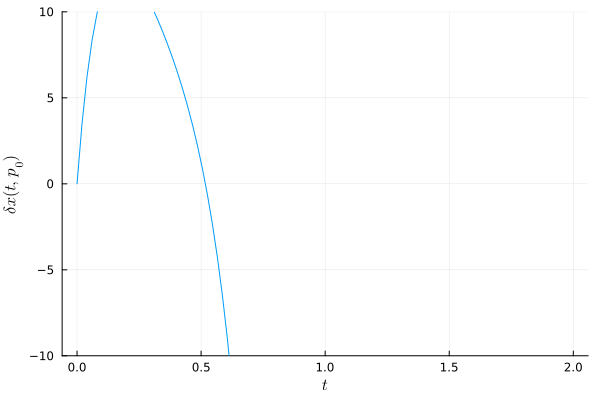

In [31]:
p0 = -0.985

N = 100
tspan = range(t0, tf, N) # time interval

δx = flow_jacobi.(tspan, t0, x0, p0)

plt_conj1 = plot()
plot!(plt_conj1, tspan, δx)  # as n=1 the det(δx) = δx
plot!(plt_conj1, xlabel=L"t", ylabel=L"\delta x(t,p_0)", legend=false, ylims=(-10.,10.))

Plots.pdf(plt_conj1, "./fig-example1/fig2_example1.pdf")
plot(plt_conj1)


Then we numerically compute the conjugate point by solving $\delta x(t)=\delta z(t,x_0,p_0)_1=0$, for $x_0=1.$ and $p_0=0.985$.

In [14]:
# compute the fisrt conjugate time 
delta_x(tau) = flow_jacobi((t0,tau),x0,p0)[1]
using Roots
tau0 = find_zero(delta_x, (0.4, 0.6))

0.51728931341542

For p0 = -0.985 tau_0 = 0.51728931341542


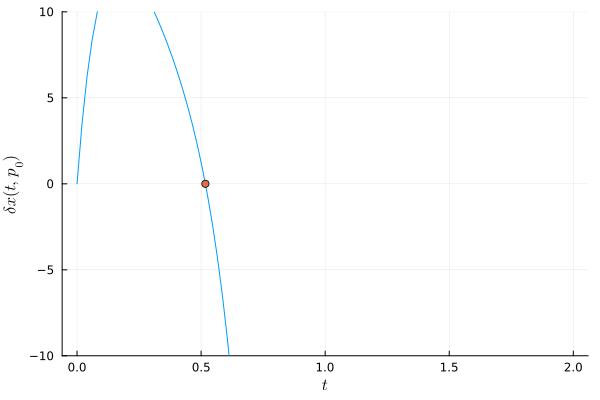

In [15]:

println("For p0 = ", p0, " tau_0 = ", tau0)

plot!(plt_conj1,[tau0],[flow_jacobi((t0,tau0),x0,p0)],seriestype=:scatter)
Plots.pdf(plt_conj1, "./fig-example1/fig3_example1.pdf")
plot(plt_conj1)

## Compute the conjugate loci
We compute conjugate loci by path following algorithm

We define $F(\tau,p_0) = \delta x(\tau,p_0)$ and we suppose that 
$\dfrac{\partial F}{\partial\tau}(\tau,p_0)$ is  inversible, then by the implicit function theorem the conjugate time is a function of $p_0$. So, as here $p_0\in\R$, we can compute them by solving the initial value problem
$$(IVP_{conj.points})\left\{
\begin{array}{l}
\dot{\tau} = -\dfrac{\partial F}{\partial\tau}(\tau,p_0)^{-1}\dfrac{\partial F}{\partial p_0}(\tau,p_0)\\
\tau(p_0) = \tau_0.
\end{array}
    \right.$$

### Remark
The derivative $\dfrac{\partial F}{\partial\tau}(\tau,p_0) = \dfrac{\partial \delta x}{\partial\tau}(\tau,p_0)$ is equal to  the first component of the second member of the Jacobi equation
$\dfrac{\partial \vec{H}}{\partial z}(z(t,z_0))\delta z(t)$.


In [16]:
# right hand side of the hamiltonian flow
Hvec! = ocp_flow.rhs!

#conjugates points by path following
"""
    Compute the right hand side of the conj.points IVP equation
    tau_point = rhs_path(tau , par, p0)
    For the structure of the rhs_path see DifferentialEquaions package
"""
function rhs_path(tau , par, p0)
    n = length(p0)
    tau1 = tau[1]     # tau is a vector
    z0 = [x0,p0]
    zpoint = similar(z0)
    Hvec!(zpoint,z0) = ocp_flow.rhs!(zpoint,z0,par,tau1)
    # zpoint is the second member of the Hamiltonian flow
    Hvec!(zpoint,z0)     
    dHvec = Matrix{typeof(p0[1])}(undef,2n,2n) # Matrix (2*n,2*n)
    # compute z(tau)
    z = ocp_flow((t0, tau1), x0, p0, reltol = 1e-8, abstol = 1e-8).ode_sol(tau1) 
  
    #derivative w.r.t. tau
    ForwardDiff.jacobian!(dHvec,Hvec!,zpoint,z) 
    delta_z = flow_jacobi((t0,tau1),x0,p0)
    dd_tau = (dHvec*delta_z)[1]    

    #derivative w.r.t. p0  
    Ftau(p0) = flow_jacobi((t0,tau1),x0,p0)[1]
    dd_p0 = ForwardDiff.derivative(Ftau, p0) 
    return [-(1/dd_tau)*dd_p0]
end

rhs_path

In [17]:
"""
   Compute the conjugate times by path by integration of the (IVP_conj.points) problem
"""
function conj_point(p0span, tau0)
    #
    pb = ODEProblem(rhs_path,[tau0],p0span,[1.])
    sol = DifferentialEquations.solve(pb, reltol = 1e-8, abstol = 1e-8)
    return sol
end


conj_point

p0 = -0.985
0.51728931341542


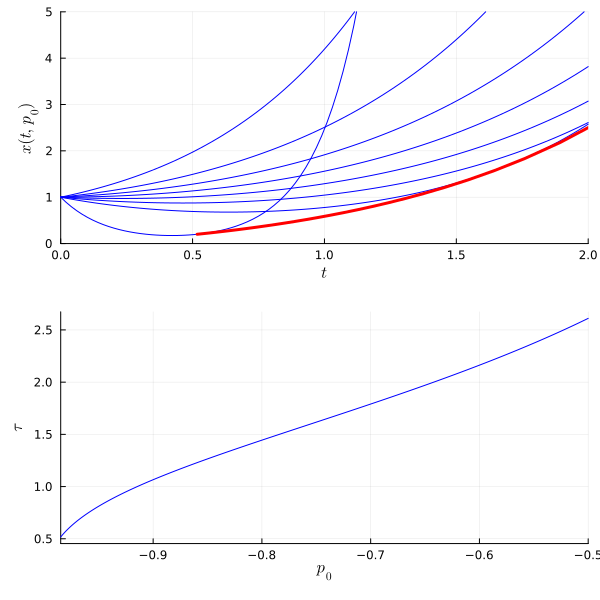

In [18]:

# conjugate point

println("p0 = ", p0)
println(tau0)

p0span = (p0, -0.5)
sol = conj_point(p0span,tau0)
plt_conj_point = plot(sol,xlabel = L"p_0", ylabel = L"\tau",color=color_trajectory)
TT = sol.u              # conjugate times
nb_t = length(sol.t)
T = zeros(nb_t)
X = zeros(nb_t)
for i in 1:nb_t
    T[i] = TT[i][1]      # τ
                         # sol.t[i] = p0
    X[i] = ocp_flow((t0, T[i][1]), x0, sol.t[i], reltol = 1e-8, abstol = 1e-8, saveat = Δt).ode_sol[1,end] # state at the conjugate time 
end

plot!(plt_x,T,X,linewidth=3,color = :red, legend=false, xlims=(0.,2.0), ylims=(0.,5.))
plt_conj2 = plot(plt_x,plt_conj_point,layout = (2,1),legend=false,size=(600,600))
Plots.pdf(plt_conj2, "./fig-example1/fig4_example1.pdf")
plot(plt_conj2)